In [1]:
# Justin Torres

In [2]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

In [3]:
coc_df = pd.read_csv("coc_clans_dataset.csv")
coc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3559743 entries, 0 to 3559742
Data columns (total 27 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   clan_tag                        object
 1   clan_name                       object
 2   clan_type                       object
 3   clan_description                object
 4   clan_location                   object
 5   isFamilyFriendly                bool  
 6   clan_badge_url                  object
 7   clan_level                      int64 
 8   clan_points                     int64 
 9   clan_builder_base_points        int64 
 10  clan_versus_points              int64 
 11  required_trophies               int64 
 12  war_frequency                   object
 13  war_win_streak                  int64 
 14  war_wins                        int64 
 15  war_ties                        int64 
 16  war_losses                      int64 
 17  clan_war_league                 object
 18  nu

In [4]:
# Based on Kaggle Info, drop columns that there is no use for.
raw_clan_df = coc_df.drop(columns=['clan_name', 'clan_description', 'clan_location', 'clan_badge_url', 'war_win_streak', 'isFamilyFriendly'])
# Want stats that show clans that have actually been used.
# Plays CWL
raw_clan_df = raw_clan_df[raw_clan_df['clan_war_league'] != 'Unranked']
# Not Empty
raw_clan_df = raw_clan_df[raw_clan_df['num_members'] != 0]
# Won at least one war.
raw_clan_df = raw_clan_df[raw_clan_df['war_wins'] > 0]
# Clan Capital is in use.
raw_clan_df = raw_clan_df[raw_clan_df['capital_league'] != 'Unranked']
# Getting Head of data because of the sheer size.
raw_clan_df = raw_clan_df.head(15000)
# Drop more columns now that activity has been proven with prior data.
raw_clan_df = raw_clan_df.drop(columns=['clan_tag', 'war_frequency', 'clan_type', 'required_builder_base_trophies', 'clan_capital_hall_level', 'clan_capital_points', 'capital_league', 'clan_builder_base_points', 'war_ties', 'war_losses', 'required_versus_trophies', 'required_townhall_level', 'mean_member_level'])
# Drop Null Values
raw_clan_df = raw_clan_df.dropna()

In [5]:
# All preprocessing goes above here.
clan_df = raw_clan_df
clan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 35 to 325945
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   clan_level            15000 non-null  int64 
 1   clan_points           15000 non-null  int64 
 2   clan_versus_points    15000 non-null  int64 
 3   required_trophies     15000 non-null  int64 
 4   war_wins              15000 non-null  int64 
 5   clan_war_league       15000 non-null  object
 6   num_members           15000 non-null  int64 
 7   mean_member_trophies  15000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 1.0+ MB


In [6]:
clan_df.describe()
# Last of data cleaning. If you want to do anything else with it, do it earlier.

,clan_level,clan_points,clan_versus_points,required_trophies,war_wins,num_members,mean_member_trophies
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,12.414933,25024.044933,24695.922667,1335.702133,166.771733,34.113800,2366.471333
std,6.489035,10068.997752,9006.289798,1300.425059,174.839587,12.118574,800.443919
min,2.000000,20.000000,0.000000,0.000000,1.000000,1.000000,41.000000
25%,7.000000,17034.750000,17973.500000,0.000000,34.000000,24.000000,1762.000000
50%,12.000000,24393.500000,24392.500000,1000.000000,99.000000,36.000000,2277.000000
75%,17.000000,32846.250000,31343.500000,2000.000000,250.000000,46.000000,2905.000000
max,36.000000,54721.000000,50500.000000,5500.000000,1323.000000,50.000000,5466.000000


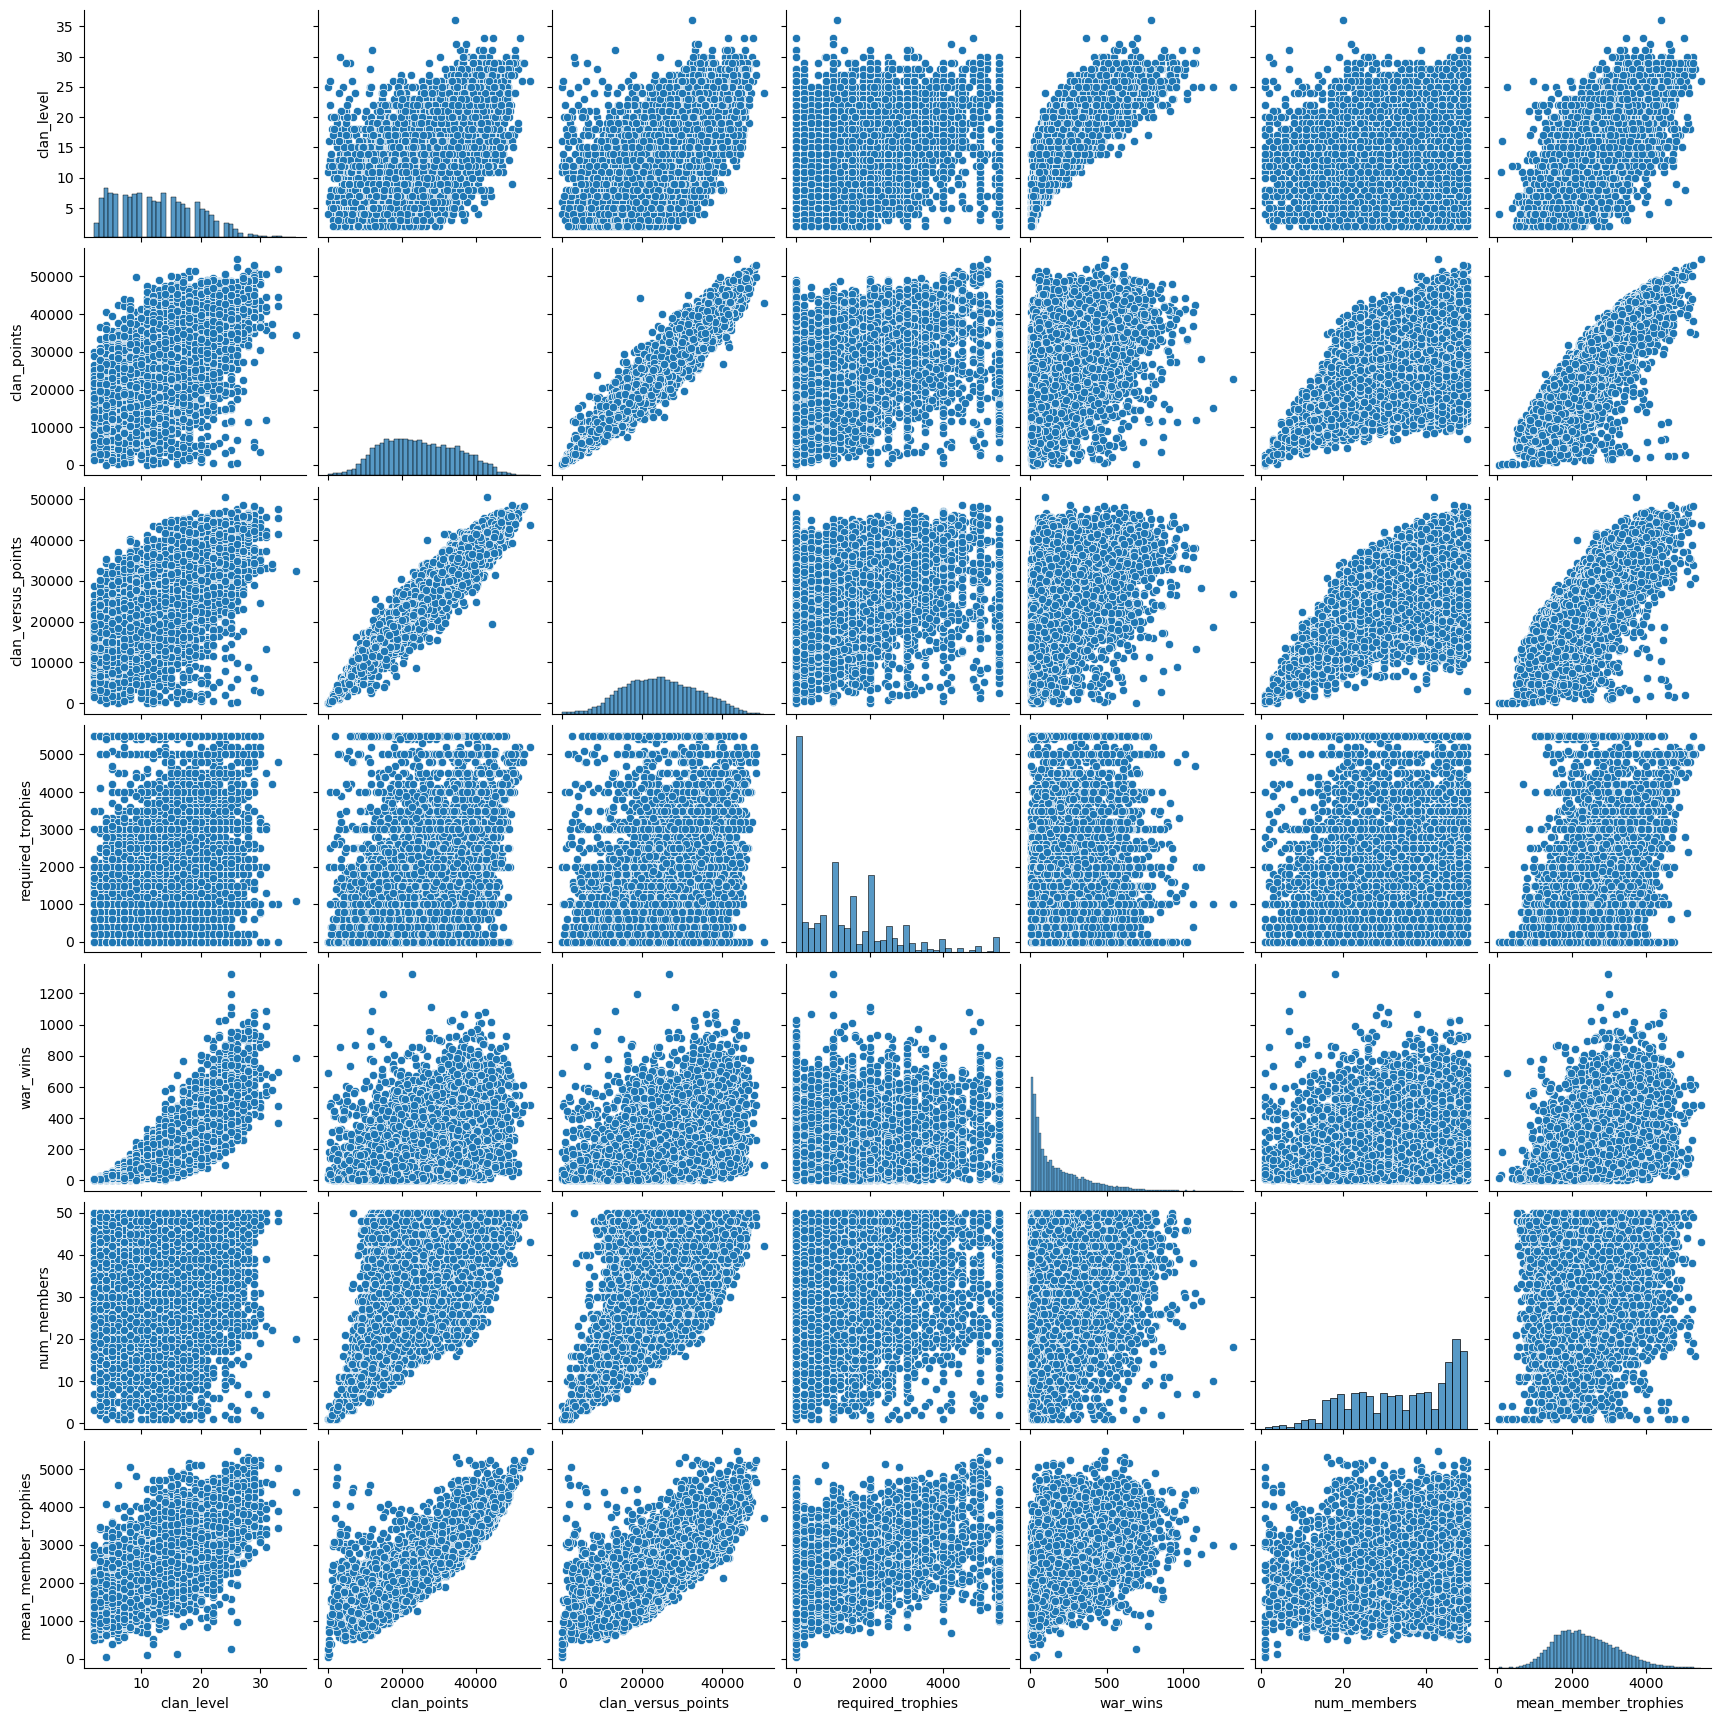

In [7]:
# Basic Correlations
sns.pairplot(clan_df)
plt.show()

In [8]:
# Logistic Regression. Labeled as classification because I forgot that classification is a broader term while Logistic Regression is a specific algorithm, and forgot to change it.
classification_df = clan_df
classification_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 35 to 325945
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   clan_level            15000 non-null  int64 
 1   clan_points           15000 non-null  int64 
 2   clan_versus_points    15000 non-null  int64 
 3   required_trophies     15000 non-null  int64 
 4   war_wins              15000 non-null  int64 
 5   clan_war_league       15000 non-null  object
 6   num_members           15000 non-null  int64 
 7   mean_member_trophies  15000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 1.0+ MB


In [9]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [10]:
# Label Encoder.
label_encoder = LabelEncoder()
classification_df['clan_war_league'] = label_encoder.fit_transform(classification_df['clan_war_league'])

In [11]:
# Label Order. I used ChatGPT to figure out the logic for implementing custom_order and custom_labels.
custom_order = ['Bronze League III', 'Bronze League II', 'Bronze League I', 'Silver League III', 'Silver League II', 'Silver League I', 'Gold League III', 'Gold League II', 'Gold League I', 'Crystal League III', 'Crystal League II', 'Crystal League I', 'Master League III', 'Master League II', 'Master League I', 'Champion League III', 'Champion League II', 'Champion League I']
custom_labels = label_encoder.transform(custom_order)

In [12]:
# Splitting, clan_war_league is the target.
X = classification_df.drop(columns=['clan_war_league'])
y = classification_df['clan_war_league']

In [13]:
# Train Test Split
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# Standard Scaler
scaler = StandardScaler()
X_trn_scaled = scaler.fit_transform(X_trn)
X_tst_scaled = scaler.transform(X_tst)


In [15]:
# Logistic Regression Model. I used ChatGPT to figure out how to use the solver, multi_class, and class_weight inputs for LogisticRegression.
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr', class_weight='balanced') 
logreg.fit(X_trn_scaled, y_trn)

C:\Users\jdt63\anaconda3\envs\itcs-3156\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr')

In [16]:
# Prediction.
y_hat = logreg.predict(X_tst_scaled)

In [17]:
# Classification Report.
print("Logistic Regression Classification Report:")
# I used ChatGPT to use classification_report and again to figure out how to use zero_division, which fixed an error.
print(classification_report(y_tst, y_hat, zero_division=1))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.02      0.11      0.03         9
           2       0.01      0.50      0.03         2
           3       0.01      0.11      0.01         9
           4       0.03      0.18      0.05        17
           5       0.08      0.16      0.10        32
           6       0.43      0.51      0.46       511
           7       0.33      0.28      0.31       474
           8       0.27      0.26      0.27       478
           9       0.28      0.23      0.26       528
          10       0.28      0.22      0.25       553
          11       0.32      0.31      0.32       572
          12       0.05      0.01      0.02        76
          13       0.26      0.28      0.27       129
          14       0.26      0.14      0.18       265
          15       0.33      0.37      0.35       436
          16       0.31      0.10     

Confusion Matrix of War Leagues:


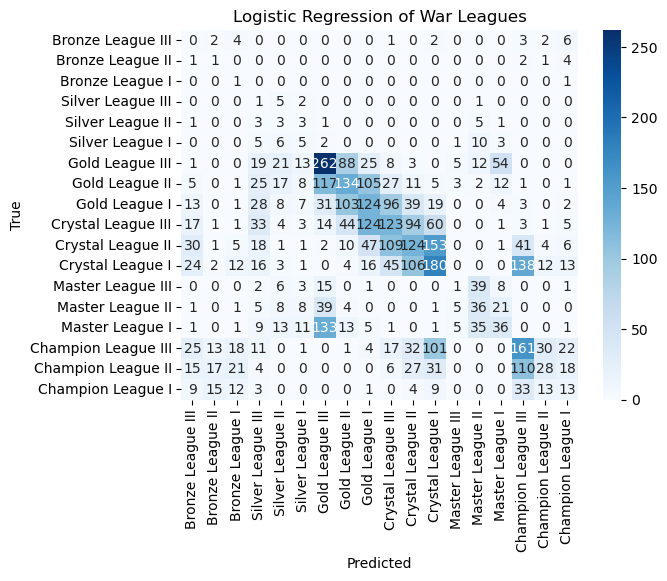

In [18]:
# Confusion Matrix and visualization.
print("Confusion Matrix of War Leagues:")
conf_matrix = confusion_matrix(y_tst, y_hat)
# I used ChatGPT for implementing the heatmap and custom_order.
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=custom_order, yticklabels=custom_order)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression of War Leagues')
plt.show()

In [19]:
# Accuracy. It doesn't look good, but considering how broad the dataset is, and that it is trying to correlate performance in a casual mode with a competitive mode, it is actually incredible.
acc = accuracy_score(y_tst, y_hat)
print(f"Accuracy Score: {acc:.4f}")

Accuracy Score: 0.2740


In [20]:
# Gaussian Naive Bayes
gnb_df = clan_df
gnb_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 35 to 325945
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   clan_level            15000 non-null  int64
 1   clan_points           15000 non-null  int64
 2   clan_versus_points    15000 non-null  int64
 3   required_trophies     15000 non-null  int64
 4   war_wins              15000 non-null  int64
 5   clan_war_league       15000 non-null  int64
 6   num_members           15000 non-null  int64
 7   mean_member_trophies  15000 non-null  int64
dtypes: int64(8)
memory usage: 1.0 MB


In [21]:
# Imports
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier

In [23]:
# Setting X and y.
X = classification_df.drop(columns=['clan_war_league'])
y = classification_df['clan_war_league']

In [24]:
# Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [25]:
# Train Test Split
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [26]:
# StandardScaler
scaler = StandardScaler()
X_trn_scaled = scaler.fit_transform(X_trn)
X_tst_scaled = scaler.transform(X_tst)

In [27]:
# Gaussian Naive Bayes. I used ChatGPT to implement this and OneVsRestClassifier.
gnb = GaussianNB()
ova_classifier = OneVsRestClassifier(gnb)

In [28]:
# Fit data.
ova_classifier.fit(X_trn_scaled, y_trn)

OneVsRestClassifier(estimator=GaussianNB())

In [29]:
# Predictions.
y_hat = ova_classifier.predict(X_tst_scaled)

In [30]:
# Accuracy.
acc = accuracy_score(y_tst, y_hat)
print(f"Accuracy Score: {acc:.4f}")

Accuracy Score: 0.2960


Confusion Matrix of War Leagues:


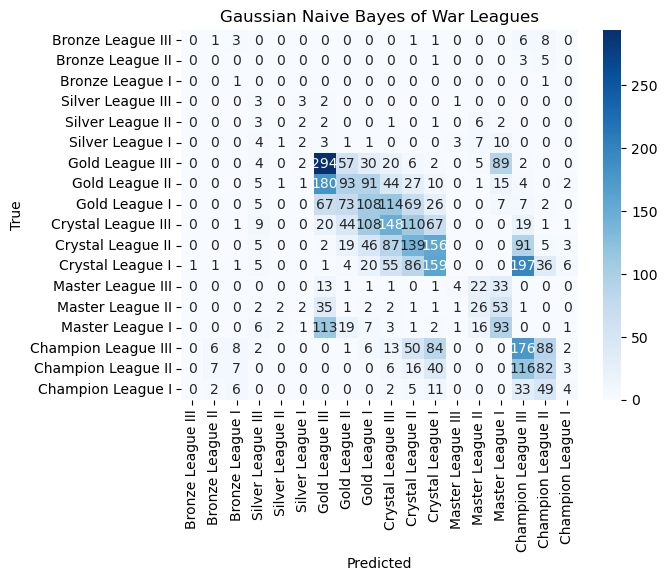

In [31]:
print("Confusion Matrix of War Leagues:")
conf_matrix = confusion_matrix(y_tst, y_hat)
# Commenting it again, but I used ChatGPT for help with heatmap syntax.
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=custom_order, yticklabels=custom_order)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gaussian Naive Bayes of War Leagues')
plt.show()

In [32]:
# JUSTIN TORRES. JUST PUTTING MY NAME IN THE FILE SOMEWHERE OTHER THAN JUST THE FILE NAME AND THE TOP.
# Classification Report.
print("Gaussian Naive Bayes Classification Report:")
# I used ChatGPT to use classification_report and again to figure out how to use zero_division, which fixed an error.
print(classification_report(y_tst, y_hat, zero_division=1))

Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00         9
           2       0.04      0.50      0.07         2
           3       0.06      0.33      0.10         9
           4       0.00      0.00      0.00        17
           5       0.15      0.06      0.09        32
           6       0.40      0.58      0.47       511
           7       0.30      0.20      0.24       474
           8       0.26      0.23      0.24       478
           9       0.30      0.28      0.29       528
          10       0.27      0.25      0.26       553
          11       0.28      0.28      0.28       572
          12       0.40      0.05      0.09        76
          13       0.31      0.20      0.25       129
          14       0.31      0.35      0.33       265
          15       0.27      0.40      0.32       436
          16       0.30      0.30    